In [1]:
import pandas as pd
import numpy as np
import time
import os
import cv2

import timm
from fastcore.all import *
from fastai.vision.all import *

In [ ]:
from bs4 import BeautifulSoup
import requests

def get_images_urls(theme, years):
    images = []
    for year in years:
        num_page = 1
        while True:
            URL = f"https://brickset.com/sets/theme-{theme}/year-{year}/page-{num_page}"
            page = requests.get(URL)

            soup = BeautifulSoup(page.content, 'html.parser')
            page_images = soup.find_all('img', src=re.compile(".jpg"))
            if len(page_images) <= 1:
                break
            images += page_images[:-1]
            num_page += 1
        # print(theme, year, len(page_images)-1)

    return [img['src'] for img in images]

def download_image_from_url(url, path, threshold_bg=0.2):
    r = requests.get(url)
    if r.status_code != 200:
        return
    arr = np.asarray(bytearray(r.content), dtype=np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)

    num_pixels = img.shape[0] * img.shape[1]
    num_background = (cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)==255).sum()

    if threshold_bg * num_pixels > num_background:
        return
    
    cv2.imwrite(path, img)

def download_set(themes, years, dir_name, max_num=1000, threshold_bg=0.2):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    
    for theme in themes:
        path_theme = f'{dir_name}/{theme}'
        if not os.path.exists(path_theme):
            os.mkdir(path_theme)

        img_urls = get_images_urls(theme, years)[:max_num]
        for it, url in enumerate(img_urls):
            download_image_from_url(url, f'{path_theme}/{it}.jpg')
        
        print(f'{theme}: {len(os.listdir(path_theme))} images')


In [ ]:
themes = ('City', 'Technic', 'Star-Wars', 'Creator', 'Ninjago', 'Architecture', 'Duplo', 'Friends', 'DC-Comics-Super-Heroes')

download_set(themes, years=[i for i in range(2005, 2020)], dir_name='train')

City: 331 images
Technic: 120 images
Star-Wars: 362 images
Creator: 148 images
Ninjago: 192 images
Architecture: 37 images
Duplo: 368 images
Friends: 219 images
DC-Comics-Super-Heroes: 67 images


In [ ]:
download_set(themes, years=[i for i in range(2020, 2022)], dir_name='validation')

City: 78 images
Technic: 27 images
Star-Wars: 56 images
Creator: 34 images
Ninjago: 52 images
Architecture: 2 images
Duplo: 36 images
Friends: 68 images
DC-Comics-Super-Heroes: 10 images


In [ ]:
# path = 'train/Technic'
# for img_name in os.listdir(path):
#     img = cv2.imread(f'{path}/{img_name}')
#     plt.imshow(img)
#     plt.xticks([]); plt.yticks([])
#     plt.show()

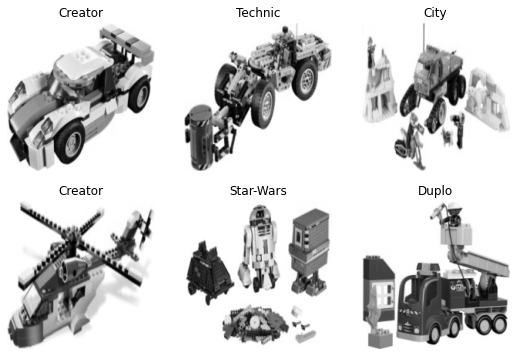

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(train_name='train', valid_name='validation'),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders('.')

dls.show_batch(max_n=6, cmap='gray')

In [ ]:
path = Path('train')
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

path = Path('validation')
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

In [ ]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=accuracy)

In [ ]:
learn.fine_tune(4)

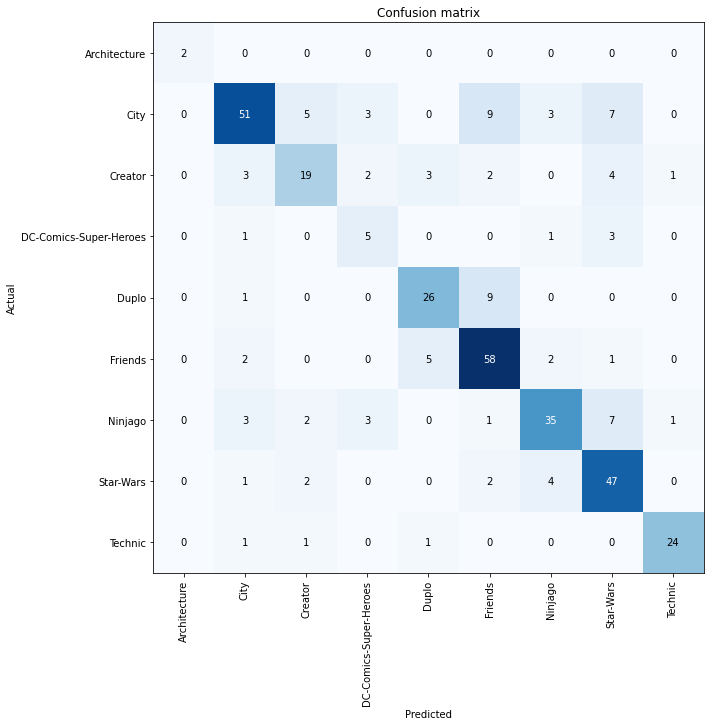

In [ ]:
# GRAYSCALE
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10))

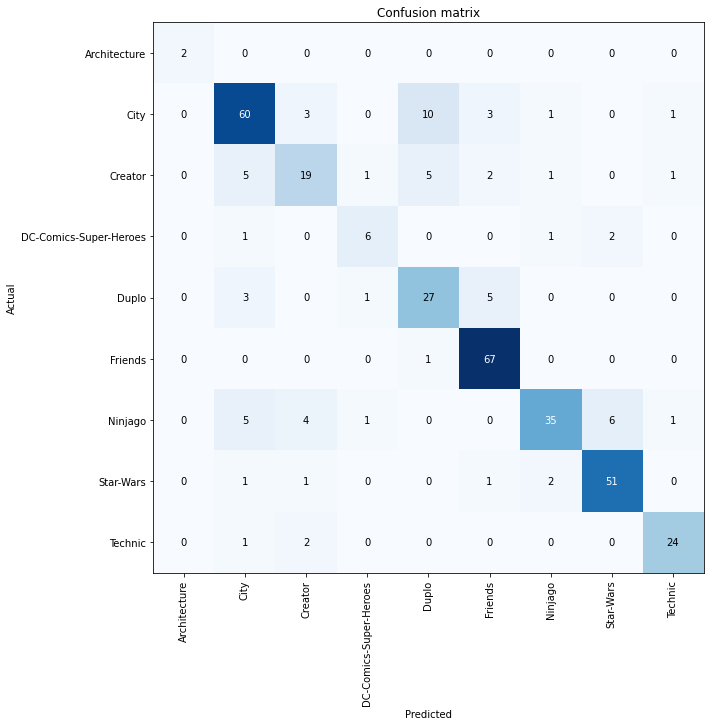

In [ ]:
# COLOR
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10))

In [ ]:
learn.export('lego_convnext_small_4ep_grayscale.pkl')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
learn.export('/content/drive/MyDrive/LegoClassification/lego_convnext_small_4ep_grayscale.pkl')